Cluster 69 contains 90 grids.


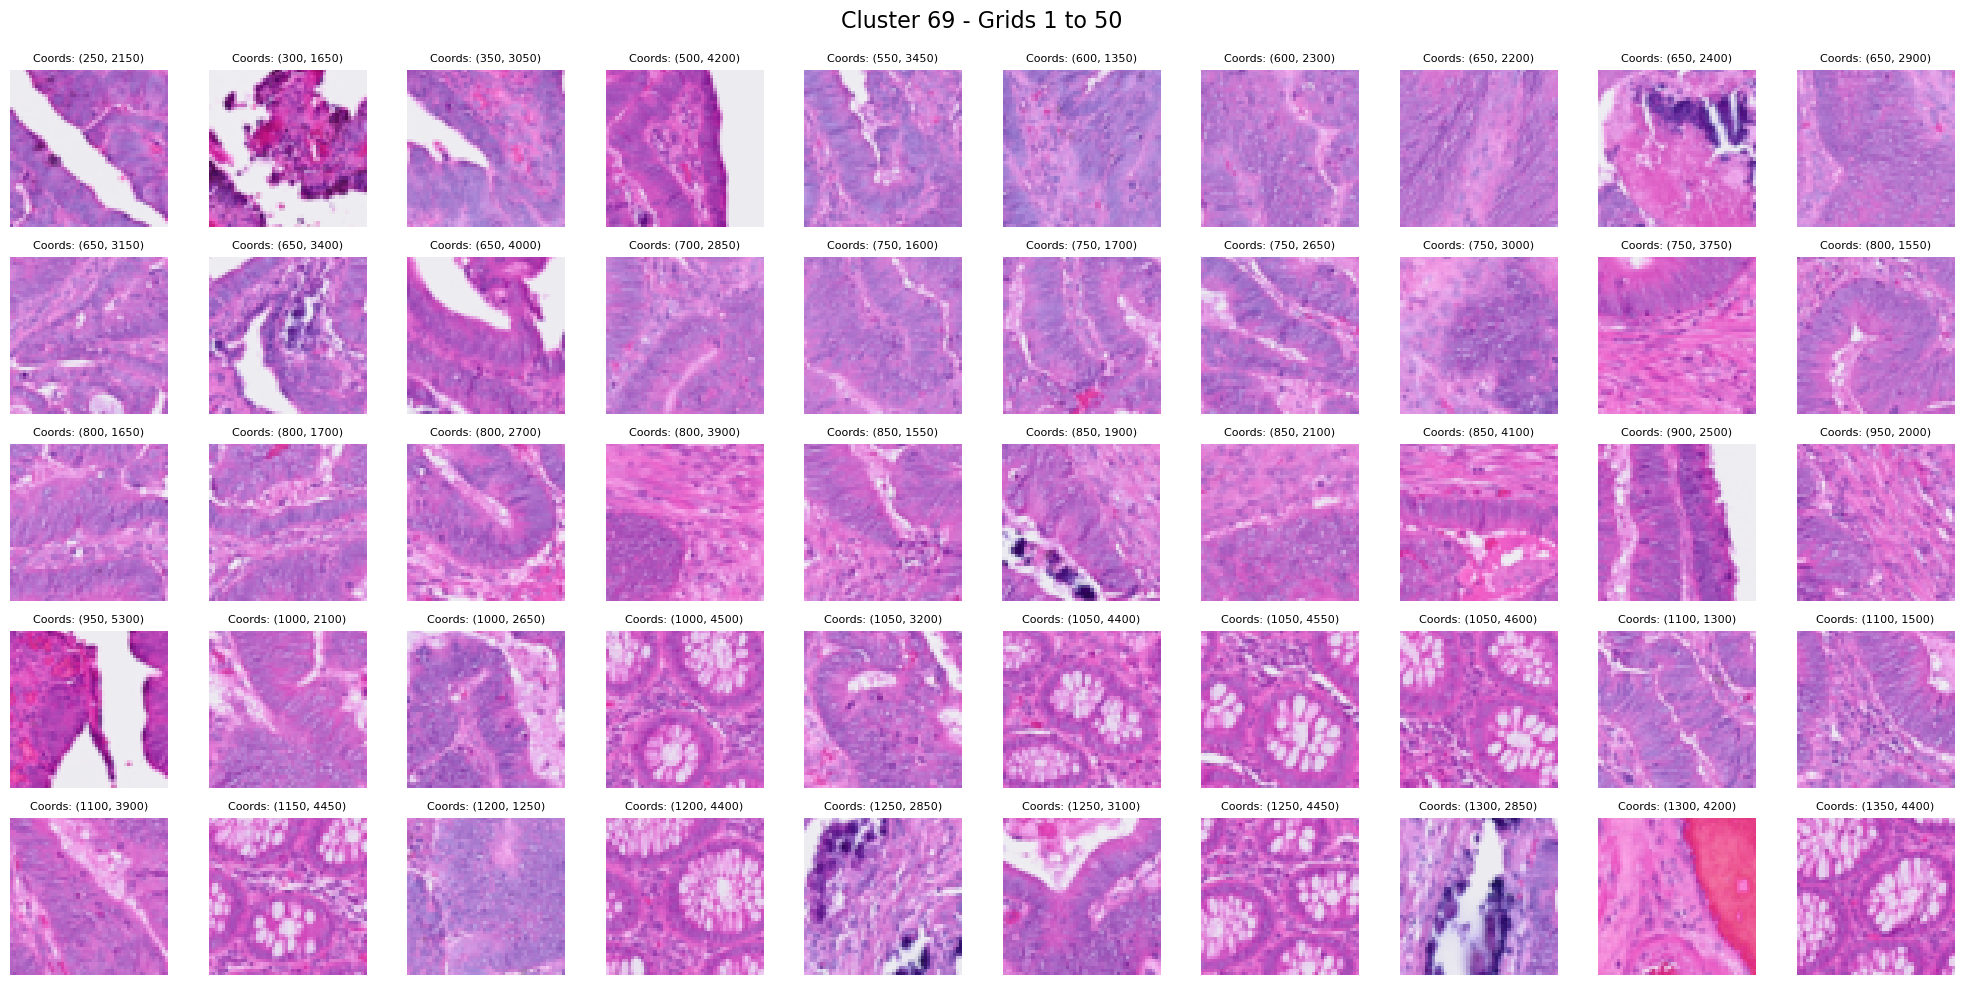

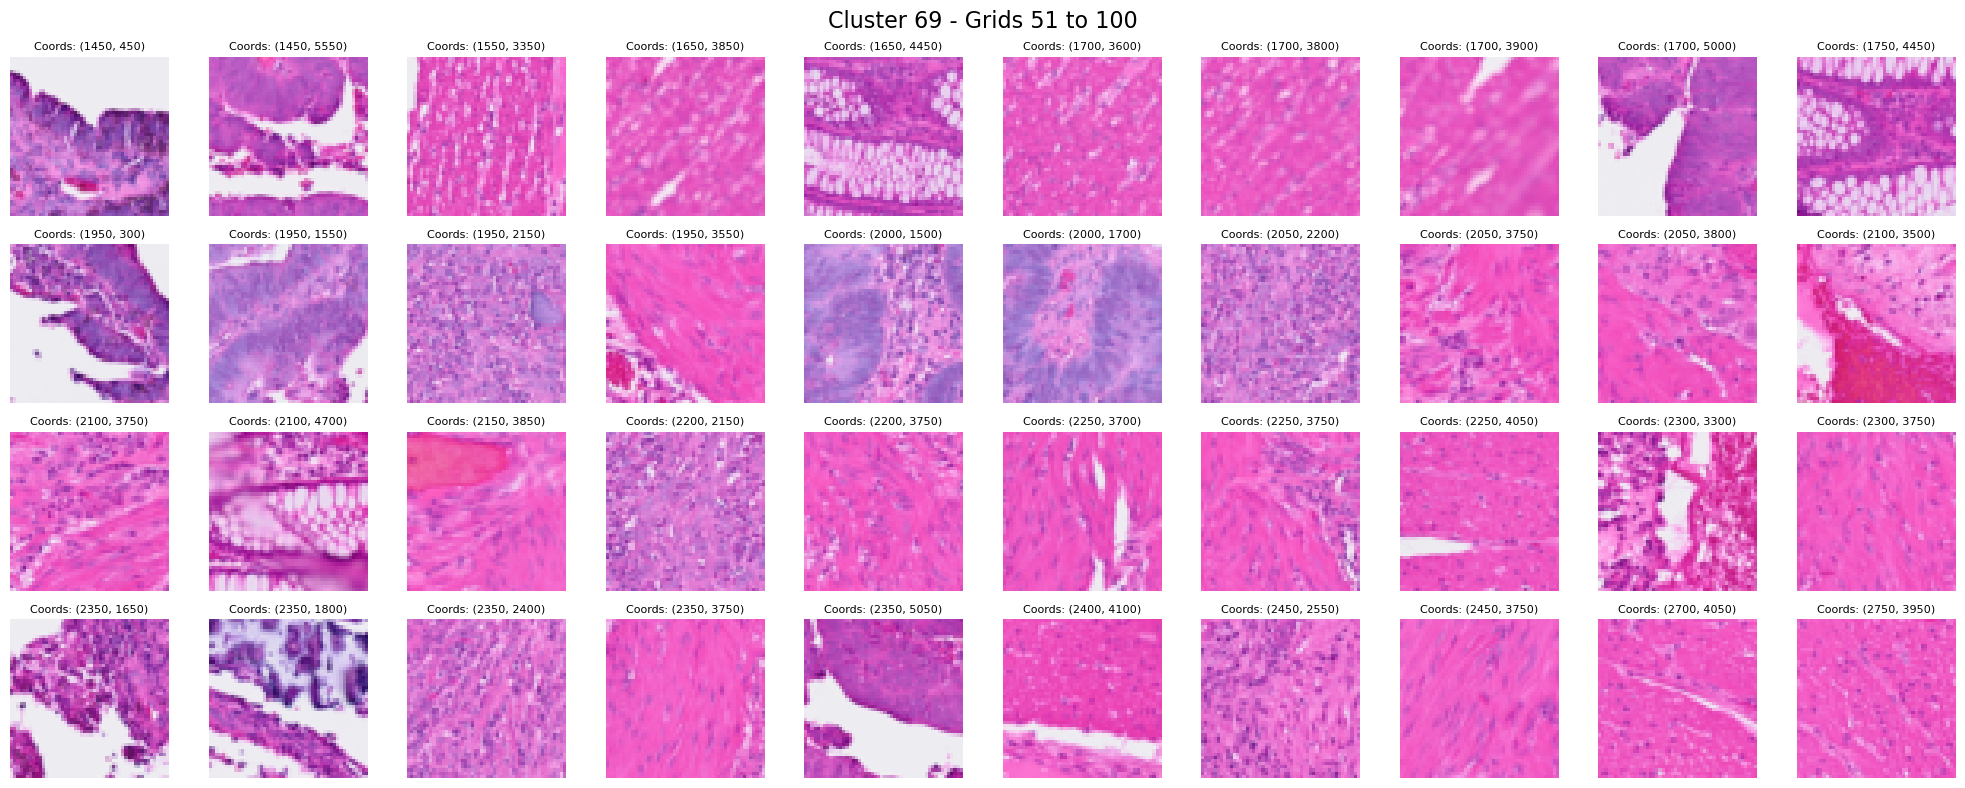

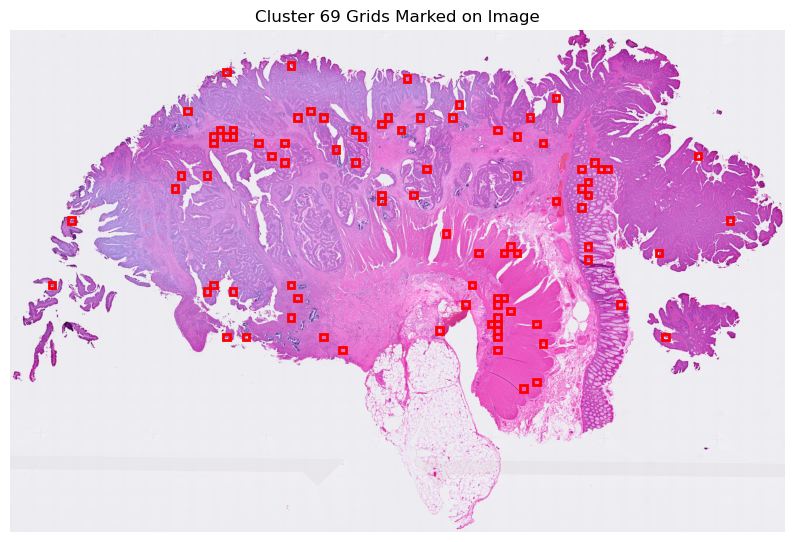

In [2]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import math
import cudf
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster import KMeans

def load_tif_image(file_path):
    """load a  TIF adn return a  NumPy array."""
    with tiff.TiffFile(file_path) as tif:
        image = tif.asarray()
    return image

def load_image(file_path):
    """Load an image file and return a NumPy array."""
    with Image.open(file_path) as img:
        image = np.array(img)
    return image[:, :, 0]  

def classify_grids_with_rapids(grids, num_clusters=10, background_threshold=240):
    """Use RAPIDS to classify grids into categories based on their mean pixel values."""
    # Extract mean pixel values
    mean_pixel_values = cp.array([grid[1] for grid in grids])
    
    # Use KMeans clustering for classification
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(mean_pixel_values.reshape(-1, 1))
    
    # Reclassify grids with mean pixel values above the background threshold as a background cluster
    labels = cp.where(mean_pixel_values > background_threshold, num_clusters, labels)
    
    # Convert to numpy array for further processing
    labels = cp.asnumpy(labels)
    
    return labels
def count_grids_in_cluster(labels, target_cluster):
    """Count the number of grids in a specific cluster."""
    return sum(1 for label in labels if label == target_cluster)

def split_into_grids(image, grid_size):
    """Split the image into grids of specified size and return a list of grids with pixel data and coordinates."""
    num_rows = (image.shape[0] + grid_size - 1) // grid_size
    num_cols = (image.shape[1] + grid_size - 1) // grid_size
    grids = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * grid_size
            end_row = min(start_row + grid_size, image.shape[0])
            start_col = j * grid_size
            end_col = min(start_col + grid_size, image.shape[1])
            grid = image[start_row:end_row, start_col:end_col]
            mean_pixel_value = np.mean(grid)
            grids.append((grid, mean_pixel_value, (start_row, start_col)))
    return grids

def visualize_cluster_in_batches(grids, labels, target_cluster, batch_size=50):
    """Visualize all grids from the specified cluster in batches to avoid memory issues."""
    cluster_grids_coords = [(grid[0], grid[2]) for grid, cluster_label in zip(grids, labels) if cluster_label == target_cluster]
    
    num_grids = len(cluster_grids_coords)
    num_batches = math.ceil(num_grids / batch_size)
    
    for batch in range(num_batches):
        batch_grids_coords = cluster_grids_coords[batch * batch_size:(batch + 1) * batch_size]
        cols = 10  # Adjust the number of columns
        rows = math.ceil(len(batch_grids_coords) / cols)
        
        fig, axs = plt.subplots(rows, cols, figsize=(20, 2 * rows))
        fig.suptitle(f"Cluster {target_cluster} - Grids {batch * batch_size + 1} to {(batch + 1) * batch_size}", fontsize=16)
        
        for ax, (grid, coords) in zip(axs.flatten(), batch_grids_coords):
            ax.imshow(grid, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Coords: {coords}", fontsize=8)
        
        for ax in axs.flatten()[len(batch_grids_coords):]:
            ax.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
    
    return cluster_grids_coords  # Return coordinates for marking on the original image

def mark_cluster_on_image(image, cluster_grids_coords, grid_size, target_cluster):
    """Mark all grids from the specified cluster on the large image."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    
    for _, coords in cluster_grids_coords:
        start_row, start_col = coords
        rect = plt.Rectangle((start_col, start_row), grid_size, grid_size, edgecolor='red', facecolor='none', lw=2)
        plt.gca().add_patch(rect)
    
    plt.title(f"Cluster {target_cluster} Grids Marked on Image")
    plt.axis('off')
    plt.show()

def count_grids_in_cluster(labels, target_cluster):
    """Count the number of grids in a specific cluster."""
    return sum(1 for label in labels if label == target_cluster)
def main():
    file_path = '/mnt/scratch2/Maycon/BioHackathon_2024/source_data/VisHD_skin_public/spatial/tissue_hires_image.tiff'
    grid_size = 50
    num_clusters= 100  # Increase this to cover clusters like 20 or 25
    background_threshold = 250
    
    image = load_tif_image(file_path)
    grids = split_into_grids(image, grid_size)
    labels = classify_grids_with_rapids(grids, num_clusters=num_clusters, background_threshold=background_threshold)
    
    # Let the user choose the target cluster
    target_cluster = int(input("Enter the cluster number you want to visualize (e.g., 10, 20, 25): "))
    
    # Count the number of grids in the chosen cluster
    cluster_count = count_grids_in_cluster(labels, target_cluster)
    print(f"Cluster {target_cluster} contains {cluster_count} grids.")
    
    if cluster_count <= 500:
        # Visualize all grids from the chosen cluster if the count is 500 or less
        cluster_coords = visualize_cluster_in_batches(grids, labels, target_cluster)

        # Mark the chosen cluster grids on the original image
        mark_cluster_on_image(image, cluster_coords, grid_size, target_cluster)
    else:
        print(f"Cluster {target_cluster} contains more than 500 grids, skipping visualization.")

if __name__ == '__main__':
    main()